In [8]:
from pvlib import pvsystem, singlediode
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from scipy.constants import e as qe, k as kB

In [9]:
# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

cell_parameters = {
    'I_L_ref': 8.24,
    'I_o_ref': 2.36e-9,
    'R_sh_ref': 1000,
      'a_ref': 1.3*Vth,
  'R_s': 0.00181,
    'alpha_sc': 0.0042,
    'breakdown_factor': 2e-3,
    'breakdown_exp': 3,
    'breakdown_voltage': -15,
}

In [10]:
def simulate_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    sde_args = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )
    # sde_args has values:
    # (photocurrent, saturation_current, resistance_series,
    # resistance_shunt, nNsVth)

    # Use Bishop's method to calculate points on the IV curve with V ranging
    # from the reverse breakdown voltage to open circuit
    kwargs = {
        'breakdown_factor': parameters['breakdown_factor'],
        'breakdown_exp': parameters['breakdown_exp'],
        'breakdown_voltage': parameters['breakdown_voltage'],
    }
    v_oc = singlediode.bishop88_v_from_i(
        0.0, *sde_args, **kwargs
    )
    # ideally would use some intelligent log-spacing to concentrate points
    # around the forward- and reverse-bias knees, but this is good enough:
    vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

    ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
    return pd.DataFrame({
        'i': ivcurve_i,
        'v': ivcurve_v,
    })

In [11]:
def plot_curves(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.5])
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

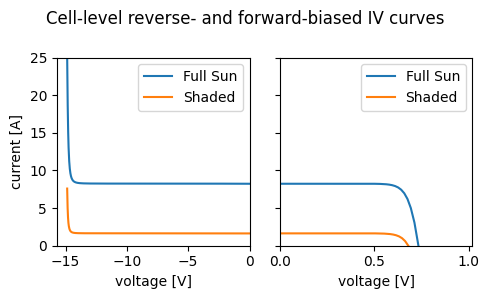

In [12]:
cell_curve_full_sun = simulate_full_curve(cell_parameters, Geff=1000, Tcell=25)
cell_curve_shaded = simulate_full_curve(cell_parameters, Geff=200, Tcell=25)
ax = plot_curves([cell_curve_full_sun, cell_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Cell-level reverse- and forward-biased IV curves')

In [13]:
def interpolate(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)

In [14]:
def combine_series(dfs):
    """
    Combine IV curves in series by aligning currents and summing voltages.
    The current range is based on the first curve's current range.
    """
    df1 = dfs[0]
    imin = df1['i'].min()
    imax = df1['i'].max()
    i = np.linspace(imin, imax, 1000)
    v = 0
    for df2 in dfs:
        v_cell = interpolate(df2, i)
        v += v_cell
    return pd.DataFrame({'i': i, 'v': v})

In [43]:
def simulate_module(cell_parameters, poa_direct, poa_diffuse, Tcell,
                    shaded_fraction, cells_per_string=20, strings=3):
    """
    Simulate the IV curve for a partially shaded module.
    The shade is assumed to be coming up from the bottom of the module when in
    portrait orientation, so it affects all substrings equally.
    For simplicity, cell temperature is assumed to be uniform across the
    module, regardless of variation in cell-level illumination.
    Substrings are assumed to be "down and back", so the number of cells per
    string is divided between two columns of cells.
    """
    # find the number of cells per column that are in full shadow
    nrow = cells_per_string // 2
    nrow_full_shade = int(shaded_fraction * nrow)
    # find the fraction of shade in the border row
    partial_shade_fraction = 1 - (shaded_fraction * nrow - nrow_full_shade)

    df_lit = simulate_full_curve(
        cell_parameters,
        poa_diffuse + poa_direct,
        Tcell)
    df_partial = simulate_full_curve(
        cell_parameters,
        poa_diffuse + partial_shade_fraction * poa_direct,
        Tcell)
    df_shaded = simulate_full_curve(
        cell_parameters,
        poa_diffuse,
        Tcell)
    # build a list of IV curves for a single column of cells (half a substring)
    include_partial_cell = (shaded_fraction < 1)
    half_substring_curves = (
        [df_lit] * (nrow - nrow_full_shade - 1)
        + ([df_partial] if include_partial_cell else [])  # noqa: W503
        + [df_shaded] * nrow_full_shade  # noqa: W503
    )
    substring_curve = combine_series(half_substring_curves)
    substring_curve['v'] *= 2  # turn half strings into whole strings
    # bypass diode:
    substring_curve['v'] = substring_curve['v'].clip(lower=-0.5)
    # no need to interpolate since we're just scaling voltage directly:
    substring_curve['v'] *= strings
    return substring_curve

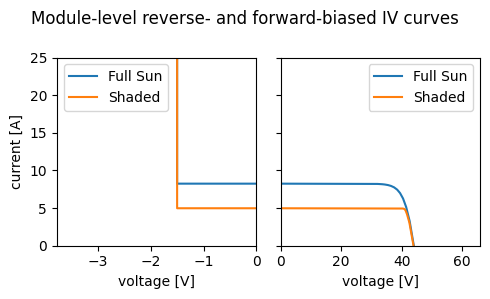

In [51]:
kwargs = {
    'cell_parameters': cell_parameters,
    'poa_direct': 800,
    'poa_diffuse': 200,
    'Tcell': 25
}
module_curve_full_sun = simulate_module(shaded_fraction=0, **kwargs)
module_curve_shaded = simulate_module(shaded_fraction=0.05, **kwargs)
ax = plot_curves([module_curve_full_sun, module_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Module-level reverse- and forward-biased IV curves')